In [139]:
# Import some libraries

!pip install torch
!pip install --upgrade tifffile
!pip install imageio
!pip install opencv-python
!pip install scikit-learn

from PIL import Image
import numpy as np
import skimage

import matplotlib.pyplot as plt
import numpy.random as npr
import scipy
from scipy.signal import fftconvolve, convolve
from scipy.signal import convolve2d
import torch
import torch.nn as nn
from skimage import color, data, restoration
from skimage import io

from skimage.util import img_as_float
from skimage.restoration import denoise_wavelet
from scipy import fftpack
import warnings

warnings.filterwarnings('ignore')

from PIL import ImageFilter
import cv2
import imageio

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.metrics import peak_signal_noise_ratio
import pandas as pd

In [2]:
# Define function to show images

def show_images(im1, im1_title, im2, im2_title, im3, im3_title, font):
    fig, (image1, image2, image3) = plt.subplots(1, 3, figsize=(15, 50))
    image1.imshow(im1, cmap='gray')
    image1.set_title(im1_title, fontsize=font)
    image1.set_axis_off()
    image2.imshow(im2, cmap='gray')
    image2.set_title(im2_title, fontsize=font)
    image2.set_axis_off()
    image3.imshow(im3, cmap='gray')
    image3.set_title(im3_title, fontsize=font)
    image3.set_axis_off()
    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                                top=0.9, bottom=0.05, left=0, right=1)
    fig.show()

In [89]:
#Load the grayscaled images
image1 = io.imread('dataset3b/1.tif')
image2 = io.imread('dataset3b/19.tif')
image3 = io.imread('dataset3b/36.tif')
image4= io.imread('dataset3b/42.tif')
image5= io.imread('dataset3b/78.tif')
image6= io.imread('dataset3b/50.tif')

#Load the kernel
psf = io.imread('PSF.tif')

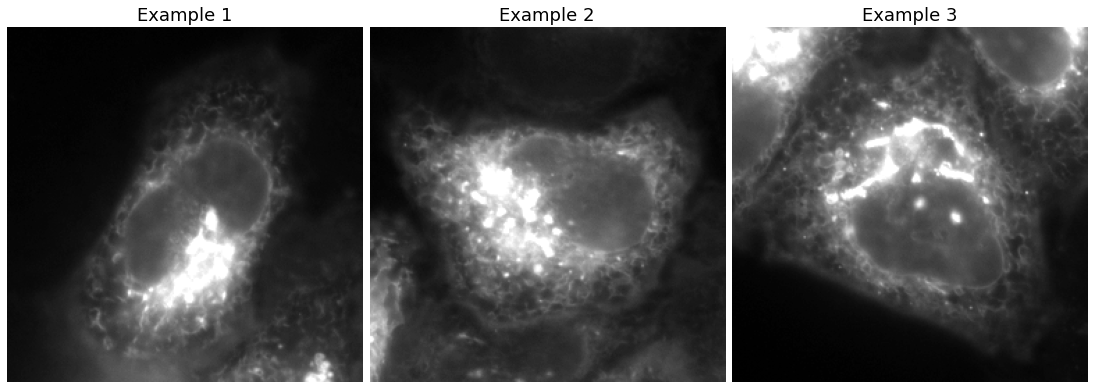

In [4]:
show_images(image1, 'Example 1', image2, 'Example 2',\
           image3, 'Example 3', font=18)

In [5]:
# To watch size in pixels
# only images with this shape can be processed by this code
image1.shape

(256, 256)

## (Naive) Inverse filtering

Convolution of two signals (or images in our case) is equal to the pointwise multiplication of their Fourier transforms, i.e.

$y(i,j) = k(i,j) \ast x(i,j) + n(i,j)$ <--> $Y(u,v) = K(u,v)X(u,v) + N(u,v)$

Consequently, the simplest approach in deconvolution is to perform element-wise division in the Fourier domain to find the underlying image $\textit{x}$:

$\hat{X}(u,v) = \frac{Y(u,v)}{K(u,v)} = \frac{K(u,v)X(u,v) + N(u,v)}{K(u,v)} = \frac{K(u,v)X(u,v)}{K(u,v)} + \frac{N(u,v)}{K(u,v)}$, 

$\hat{x}(i,j) = F^{-1}\hat{X}(u,v)$

For this task let's firstly consider the case of an image corrupted with blur only.

In [6]:
# First (failed) solution
Y = fftpack.fft2(image3)

# Let's do all necessary modifications with the PSF before applying Fourier transform:

kernel_size = (image3.shape[0] - psf.shape[0], image3.shape[1] - psf.shape[1])  
psf = np.pad(psf, (((kernel_size[0]+1)//2, kernel_size[0]//2), \
                    ((kernel_size[1]+1)//2, kernel_size[1]//2)), 'constant')
kernel = fftpack.ifftshift(psf)

K = fftpack.fft2(kernel)

X_hat = Y/K

x_hat = fftpack.ifft2(X_hat).real

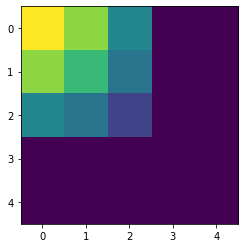

In [7]:
plt.imshow(kernel[:5, :5])

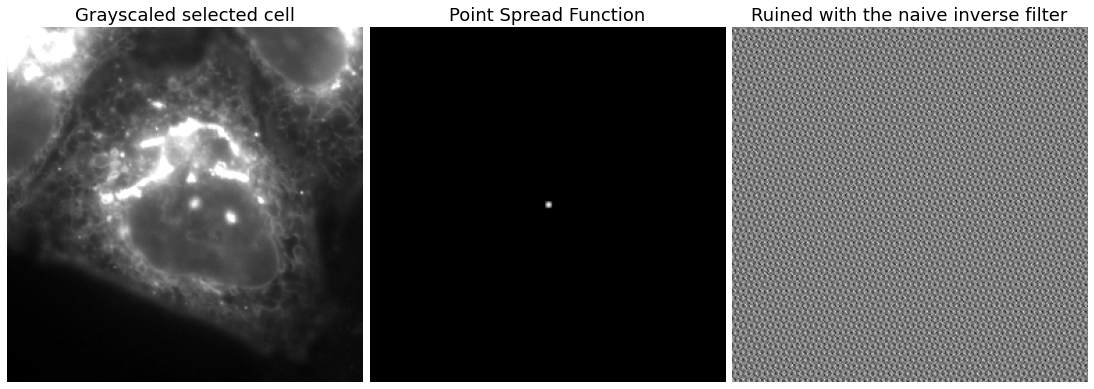

In [8]:
show_images(image3, 'Grayscaled selected cell', psf, 'Point Spread Function',\
           x_hat, 'Ruined with the naive inverse filter', font=18)

Inverse filter can't provide good results with noisy images because of the noise amplification

## Convolution: sharpen, low pass and smooth filters

Python Image processing library (Pillow) have ready to use Sharpen-filter, which returns sharpened image

Default convolution matrix is 3x3 matrix: 
  
-2, -2, -2,   

-2, 32, -2,  

-2, -2, -2

<em>sharpened1 = image1.filter(ImageFilter.SHARPEN)</em>

But custom matrix can be used with cv2  
(for more information, read Python Examples)

#### Low Pass Filter

In [9]:
# read image for cv2
img_cv = cv2.imread('dataset3b/50.tif')

# prepare the 5x5 shaped filter
kernel1 = np.array([[1., 1., 1.], 
                   [1., 1., 1.], 
                   [1., 1., 1.]])
kernel1 = kernel1/sum(kernel1)

# filter the image
img_out = cv2.filter2D(img_cv,-1,kernel1)

# save result
cv2.imwrite('result.tif',img_out)

# importing result
cv_result= io.imread('result.tif')

cv2.waitKey(0)
cv2.destroyAllWindows()

#### Sharpen-filter

In [10]:
# read image
img_cv2 = cv2.imread('dataset3b/50.tif')

# prepare the 5x5 shaped filter
kernel2 = np.array([[-9., -9., -9.], 
                   [-9., 120., -9.], 
                   [-9., -9., -9.]])

kernel2 = kernel2/(np.sum(kernel2) if np.sum(kernel2)!=0 else 1)

# filter the image
img_out2 = cv2.filter2D(img_cv2,-1,kernel2)

# save result
cv2.imwrite('result2.tif',img_out2)

# importing result
cv_result2= io.imread('result2.tif')

cv2.waitKey(0)
cv2.destroyAllWindows()

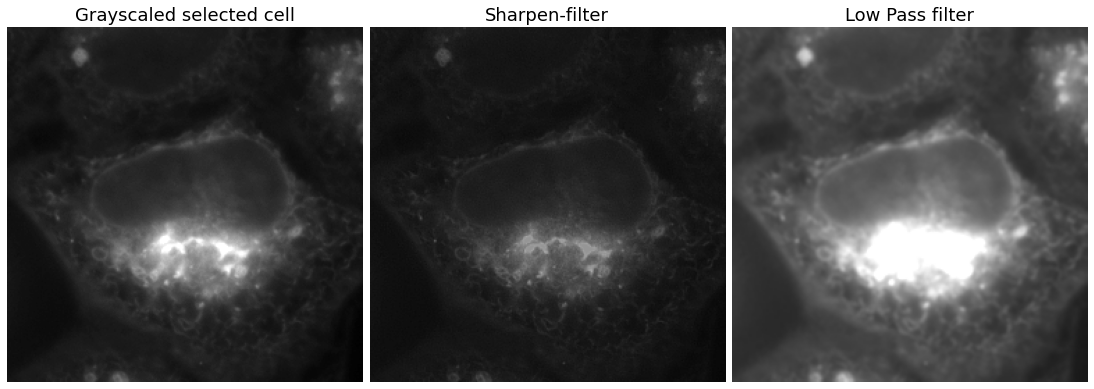

In [11]:
show_images(image6, 'Grayscaled selected cell', cv_result2, 'Sharpen-filter',\
           cv_result, 'Low Pass filter', font=18)

Kernel with ones amplified light (third image), the other one makes an image sharpen (the second). This can be compared to the original image (the first one).

#### Smooth-filter

In [12]:
# read image
img_cv3 = cv2.imread('result2.tif')

# prepare the 5x5 shapen filter
kernel3 = np.array([[1., 1., 1.],
                   [1., 33., 1.], 
                   [1., 1., 1.]])

kernel3 = kernel3/(np.sum(kernel3) if np.sum(kernel3)!=0 else 1)

# filter the image
img_out3 = cv2.filter2D(img_cv3,-1,kernel3)

# save result
cv2.imwrite('result3.tif',img_out3)

# importing result
cv_result3= io.imread('result3.tif')

cv2.waitKey(0)
cv2.destroyAllWindows()

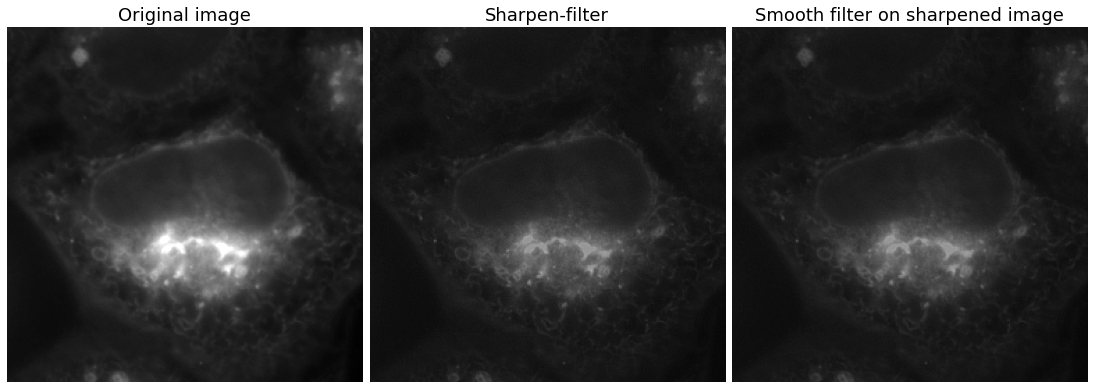

In [13]:
show_images(image6, 'Original image', cv_result2, 'Sharpen-filter',\
           cv_result3, 'Smooth filter on sharpened image', font=18)

Compare to the original one, sharpen looks better because of explicit edges. Smooth filter makes edges less explicit, but more soft.

## Richardson-Lucy deconvolution

<img src="poisson.png" alt="Drawing" style="width: 300px;"/>
Image formation is described as following:
$\mathbf{y}_n = \mathcal{P}(\mathbf{Kx}_n)$, where $\mathcal{P}$ denotes Poisson noise disturbing the image, $\mathbf{y}_n, \mathbf{x}_n\ \text{and}\ \mathbf{K}$ denote vector representations of the data.

Richardson-Lucy deconvolution algotithm is based on the Bayes rule as following:
$p\left(\mathbf{y}_{n} \mid \mathbf{x}\right)=\frac{(\mathbf{K} \mathbf{x})_{n}^{\mathbf{y}_{n}} e^{-(\mathbf{K} \mathbf{x})_{n}}}{\mathbf{y}_{n} !}$

Maximization of probability $p\left(\mathbf{y}_{n} \mid \mathbf{x}\right)$ is equivalent to minimizartion of log probability

$\log (p(\mathbf{y} \mid \mathbf{x}))=\log (\mathbf{K} \mathbf{x})^{T} \mathbf{y}-(\mathbf{K} \mathbf{x})^{T} \mathbf{1}-\sum_{i=1}^{M} \log \left(\mathbf{y}_{n} !\right)$

Three main conditions:
- $J = -log(p(\mathbf{y}|\mathbf{x})), \nabla{J} = 0$ - at solution gradient is zero;

- $\frac{\mathbf{x}_{i+1}}{\mathbf{x}_i} = 1$ - when converged, further iterations do not change;

- PSF is normalized such that sum of elements equals to 1.

We can form the Richardson-Lucy multiplicative update rule:
$\mathbf{x}_{i+1}=\mathbf{K}^{T} \odot(\mathbf{K} \mathbf{x})^{-1} \odot \mathbf{y} \odot \mathbf{x}_{i}$

In [104]:
im_deconv = image6.copy()

# Set number of Richardson-Lucy iterations
iterations = 10

for _ in range(iterations):
    print('Running Richardson-Lucy iteration {}'.format(_+1))
    # Calculate Kx
    Kx = convolve2d(im_deconv, psf[::-1, ::-1], mode='same', boundary='symm')
    # Calculate (Kx)^-1 (*) y
    relative_blur = image6/Kx
    # Calculate K^T(*) (Kx)^-1 (*) y
    KTx = convolve2d(relative_blur, psf[::-1, ::-1], mode='same', boundary='symm')
    im_deconv = KTx * im_deconv

Running Richardson-Lucy iteration 1
Running Richardson-Lucy iteration 2
Running Richardson-Lucy iteration 3
Running Richardson-Lucy iteration 4
Running Richardson-Lucy iteration 5
Running Richardson-Lucy iteration 6
Running Richardson-Lucy iteration 7
Running Richardson-Lucy iteration 8
Running Richardson-Lucy iteration 9
Running Richardson-Lucy iteration 10


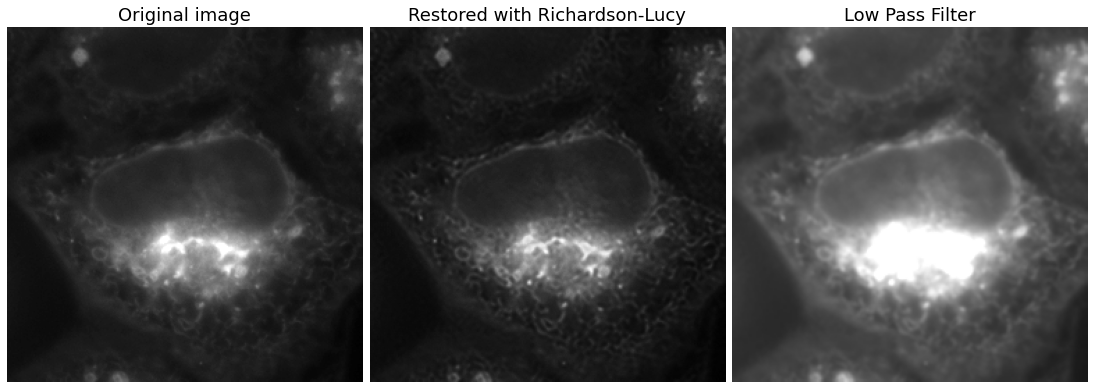

In [105]:
show_images(image6, 'Original image', im_deconv, 'Restored with Richardson-Lucy',\
           cv_result, 'Low Pass Filter', font=18)

#### Another problem

How can we deal with the problem of overexposure zones?

As we can see, this problem can иу partially solved by using Sharpen-filter and Richardson-Lucy deconvolution.
Why is this happening?
To localize the fluorescent protein (FP) within the cell, a long exposure time is required when shooting, but this increases the illumination in the center of the cell (maximum localization of FP). 

Unfortunately, this problem results with the loss of data in the center of the cell.

What PSF actually does?
If PSF is round, we 'compress' the data to the center. We can use it to make edges more explicit, but we cannot recover lost data in overexposure zones. For example, DeblurGAN can be used as another approach.

If the image is full of noise, deconvolution algorithm can take these noisy dots and compress them with PSF. But the problem is possible noise amplification (or rather 'compression').

Regularization limits the function processing to avoid noise amplification.

Convolution can be simply defined as a matrix multiplication in Fourier space from minus infinity to infinity.
Fourier space is a mathematical 'black box' with Delta-functions.

In [16]:
im_deconv2 = image6.copy()

# Set number of Richardson-Lucy iterations
iterations = 20

for _ in range(iterations):
    print('Running Richardson-Lucy iteration {}'.format(_+1))
    # Calculate Kx
    Kx = convolve2d(im_deconv2, psf[::-1, ::-1], mode='same', boundary='symm')
    # Calculate (Kx)^-1 (*) y
    relative_blur = image6/Kx
    # Calculate K^T(*) (Kx)^-1 (*) y
    KTx = convolve2d(relative_blur, psf[::-1, ::-1], mode='same', boundary='symm')
    im_deconv2 = KTx * im_deconv2

Running Richardson-Lucy iteration 1
Running Richardson-Lucy iteration 2
Running Richardson-Lucy iteration 3
Running Richardson-Lucy iteration 4
Running Richardson-Lucy iteration 5
Running Richardson-Lucy iteration 6
Running Richardson-Lucy iteration 7
Running Richardson-Lucy iteration 8
Running Richardson-Lucy iteration 9
Running Richardson-Lucy iteration 10
Running Richardson-Lucy iteration 11
Running Richardson-Lucy iteration 12
Running Richardson-Lucy iteration 13
Running Richardson-Lucy iteration 14
Running Richardson-Lucy iteration 15
Running Richardson-Lucy iteration 16
Running Richardson-Lucy iteration 17
Running Richardson-Lucy iteration 18
Running Richardson-Lucy iteration 19
Running Richardson-Lucy iteration 20


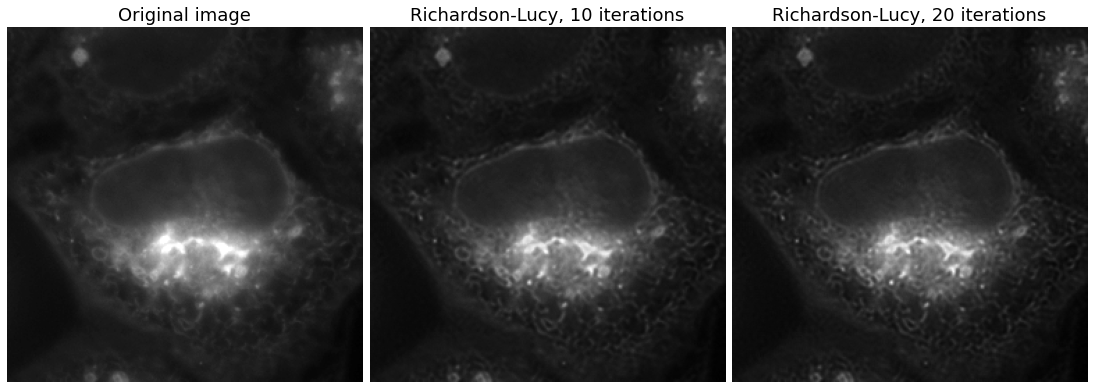

In [17]:
show_images(image6, 'Original image', im_deconv, 'Richardson-Lucy, 10 iterations',\
           im_deconv2, 'Richardson-Lucy, 20 iterations', font=18)

In [18]:
im_deconv3 = image6.copy()

#Set number of Richardson-Lucy iterations
iterations = 40

for _ in range(iterations):
    print('Running Richardson-Lucy iteration {}'.format(_+1))
    # Calculate Kx
    Kx = convolve2d(im_deconv3, psf[::-1, ::-1], mode='same', boundary='symm')
    # Calculate (Kx)^-1 (*) y
    relative_blur = image6/Kx
    # Calculate K^T(*) (Kx)^-1 (*) y
    KTx = convolve2d(relative_blur, psf[::-1, ::-1], mode='same', boundary='symm')
    im_deconv3 = KTx * im_deconv3

Running Richardson-Lucy iteration 1
Running Richardson-Lucy iteration 2
Running Richardson-Lucy iteration 3
Running Richardson-Lucy iteration 4
Running Richardson-Lucy iteration 5
Running Richardson-Lucy iteration 6
Running Richardson-Lucy iteration 7
Running Richardson-Lucy iteration 8
Running Richardson-Lucy iteration 9
Running Richardson-Lucy iteration 10
Running Richardson-Lucy iteration 11
Running Richardson-Lucy iteration 12
Running Richardson-Lucy iteration 13
Running Richardson-Lucy iteration 14
Running Richardson-Lucy iteration 15
Running Richardson-Lucy iteration 16
Running Richardson-Lucy iteration 17
Running Richardson-Lucy iteration 18
Running Richardson-Lucy iteration 19
Running Richardson-Lucy iteration 20
Running Richardson-Lucy iteration 21
Running Richardson-Lucy iteration 22
Running Richardson-Lucy iteration 23
Running Richardson-Lucy iteration 24
Running Richardson-Lucy iteration 25
Running Richardson-Lucy iteration 26
Running Richardson-Lucy iteration 27
Running Ri

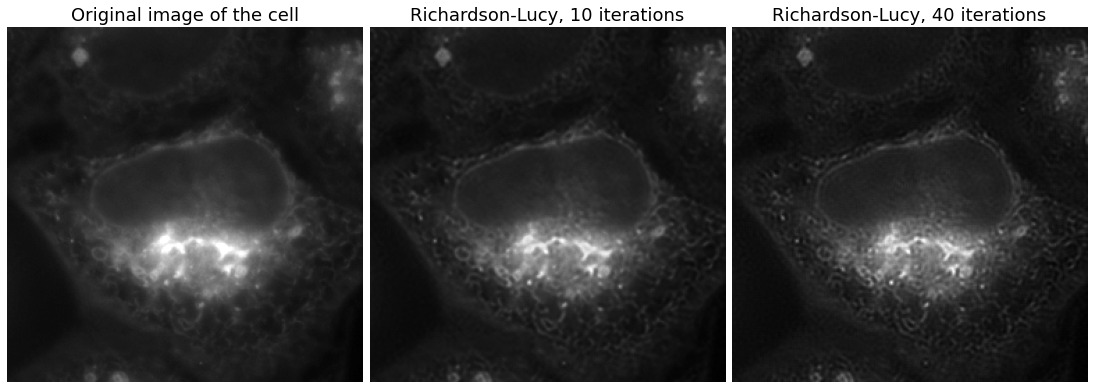

In [23]:
show_images(image6, 'Original image of the cell', im_deconv, 'Richardson-Lucy, 10 iterations',\
           im_deconv3, 'Richardson-Lucy, 40 iterations', font=18)

As it shown above, the simple addition of iterations cannot improve the image. However, it becomes more distorted and noisy.

### Combined approach

In [64]:
imageio.imwrite('im_deconv.bmp', im_deconv)

Lossy conversion from float64 to uint8. Range [6.845409698500358, 175.82535325768086]. Convert image to uint8 prior to saving to suppress this warning.


In [98]:
# Apply Sharpen-filter

img_cv4 = cv2.imread('im_deconv.bmp')

# prepare the 5x5 shaped filter
kernel4 = np.array([[-5., -5., -5.], 
                   [-5., 133., -5.], 
                   [-5., -5., -5.]])

kernel4 = kernel4/(np.sum(kernel4) if np.sum(kernel4)!=0 else 1)

# filter the image
img_out4 = cv2.filter2D(img_cv4,-1,kernel4)

# save result
cv2.imwrite('deconv_sharpen.tif',img_out4)

# importing result
cv_result4= io.imread('deconv_sharpen.tif')

cv2.waitKey(0)
cv2.destroyAllWindows()

In [99]:
# Apply Smooth-filter with previous Smooth-kernel

# The input image
img_cv5 = cv2.imread('deconv_sharpen.tif')

# filter the image
img_out5 = cv2.filter2D(img_cv5,-1,kernel3)

# save result
cv2.imwrite('result5.tif',img_out5)

# importing result
cv_result5= io.imread('result5.tif')

cv2.waitKey(0)
cv2.destroyAllWindows()

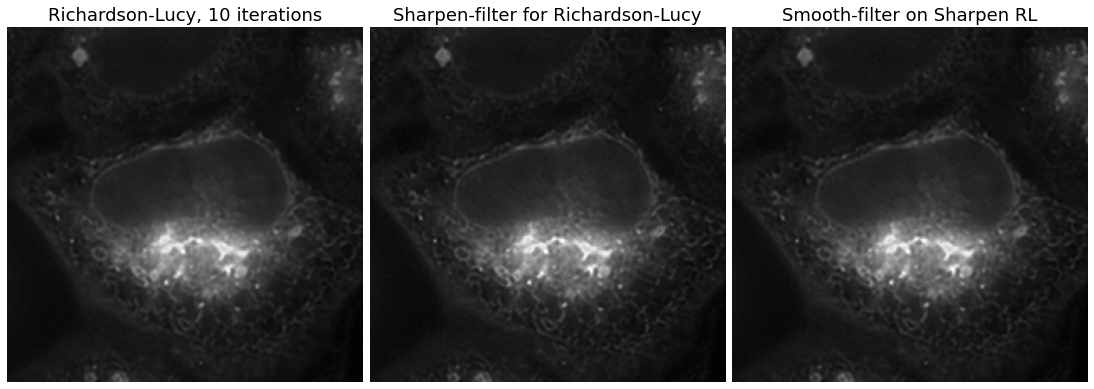

In [100]:
 show_images(img_cv4, 'Richardson-Lucy, 10 iterations', cv_result4, 'Sharpen-filter for Richardson-Lucy',\
           cv_result5, 'Smooth-filter on Sharpen RL', font=18)

As it been shown in illustration above, combined approach seems to be one of the best for visualization.

## Include Total-Variation regularization 

Total-variation implies regularization of the gradient of the image. It is based on the principle that signals with excessive and possibly spurious detail have high total variation (c) Wikipedia.

With inclusion of a regularization the solution yields the form

$J = -(\log (p(\mathbf{y} \mid \mathbf{x}))=\log (\mathbf{K} \mathbf{x})^{T} \mathbf{y}-(\mathbf{K} \mathbf{x})^{T} \mathbf{1}-\sum_{i=1}^{M} \log \left(\mathbf{y}_{n} !\right)) + \lambda|\nabla\mathbf{x}|$.

Finally, the Richardson-Lucy multiplicative update rule has the shape of

$\mathbf{x}_{i+1}=\mathbf{K}^{T} \odot(\mathbf{K} \mathbf{x})^{-1} \odot \mathbf{y} \odot \frac{\mathbf{x}_{i}}{1 - \lambda \text{div}\left( \frac{\nabla{\mathbf{x}}}{|\nabla{\mathbf{x}}|} \right)}$.

In [109]:
def tv_grad(image_to_norm, lamda):
    
    #Let's calculate image gradients over x and y axis (\nabla{x})
    dx = np.gradient(image_to_norm)[1] 
    dy = np.gradient(image_to_norm)[0]
    
    #We add small epsilon value to avoid numerical instability
    eps = 1e-6
    
    norm = np.sqrt(dx*dx + dy*dy) #|\nabla{x}|
    ndx = dx.copy()
    ndy = dy.copy()
    
    ndx[norm<eps] = eps
    ndy[norm<eps] = eps
    
    #Calculate (\nabla{x}/|\nabla{x}|) over x and y axis
    ndx[norm>=eps] = dx[norm>=eps] / norm[norm>=eps]
    ndy[norm>=eps] = dy[norm>=eps] / norm[norm>=eps]
    
    #Calculate gradients of the equation above over x and y axis
    ddx = np.gradient(ndx)[1] 
    ddy = np.gradient(ndx)[0] 

    #Calculate TV-part of the equation
    tv_part = 1/(1 - (ddx + ddy)*lamda)
    del ndx, ndy, ddx, ddy, dx, dy
    
    return tv_part

In [110]:
im_deconv_regulated = image6.copy()

#Set number of Richardson-Lucy iterations
iterations = 10

for _ in range(iterations):
    print('Running Richardson-Lucy iteration {}'.format(_+1))
    # Calculate Kx
    Kx = convolve2d(im_deconv_regulated, psf[::-1, ::-1], mode='same', boundary='symm')
    # Calculate (Kx)^-1 (*) y
    relative_blur = image6/Kx
    # Calculate K^T(*) (Kx)^-1 (*) y
    KTx = convolve2d(relative_blur, psf[::-1, ::-1], mode='same', boundary='symm')
    im_deconv_regulated = tv_grad(im_deconv_regulated, 1e-2)* KTx * im_deconv_regulated

Running Richardson-Lucy iteration 1
Running Richardson-Lucy iteration 2
Running Richardson-Lucy iteration 3
Running Richardson-Lucy iteration 4
Running Richardson-Lucy iteration 5
Running Richardson-Lucy iteration 6
Running Richardson-Lucy iteration 7
Running Richardson-Lucy iteration 8
Running Richardson-Lucy iteration 9
Running Richardson-Lucy iteration 10


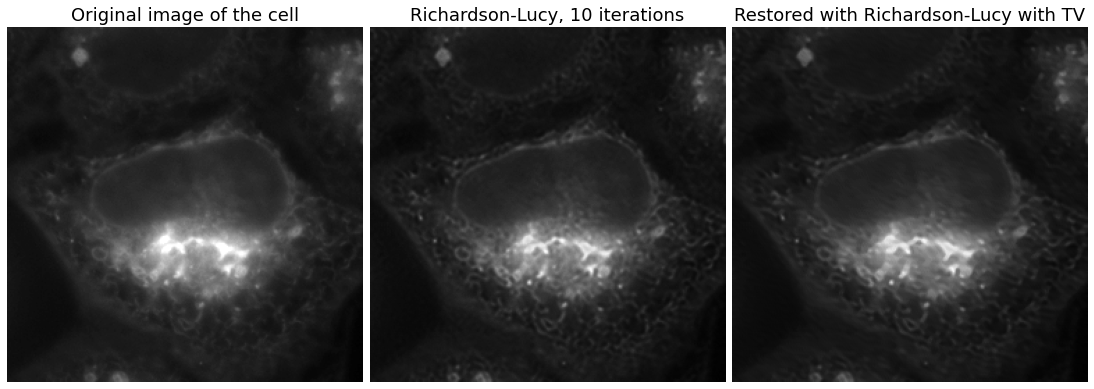

In [111]:
show_images(image6, 'Original image of the cell', im_deconv, 'Richardson-Lucy, 10 iterations',\
           im_deconv_regulated, 'Restored with Richardson-Lucy with TV', font=18)

Somehow, regilarization makes image more smooth.

In [115]:
im_deconv_another = image1.copy()

#Set number of Richardson-Lucy iterations
iterations = 30

for _ in range(iterations):
    print('Running Richardson-Lucy iteration {}'.format(_+1))
    # Calculate Kx
    Kx = convolve2d(im_deconv_another, psf[::-1, ::-1], mode='same', boundary='symm')
    # Calculate (Kx)^-1 (*) y
    relative_blur = image1/Kx
    # Calculate K^T(*) (Kx)^-1 (*) y
    KTx = convolve2d(relative_blur, psf[::-1, ::-1], mode='same', boundary='symm')
    im_deconv_another = KTx * im_deconv_another

Running Richardson-Lucy iteration 1
Running Richardson-Lucy iteration 2
Running Richardson-Lucy iteration 3
Running Richardson-Lucy iteration 4
Running Richardson-Lucy iteration 5
Running Richardson-Lucy iteration 6
Running Richardson-Lucy iteration 7
Running Richardson-Lucy iteration 8
Running Richardson-Lucy iteration 9
Running Richardson-Lucy iteration 10
Running Richardson-Lucy iteration 11
Running Richardson-Lucy iteration 12
Running Richardson-Lucy iteration 13
Running Richardson-Lucy iteration 14
Running Richardson-Lucy iteration 15
Running Richardson-Lucy iteration 16
Running Richardson-Lucy iteration 17
Running Richardson-Lucy iteration 18
Running Richardson-Lucy iteration 19
Running Richardson-Lucy iteration 20
Running Richardson-Lucy iteration 21
Running Richardson-Lucy iteration 22
Running Richardson-Lucy iteration 23
Running Richardson-Lucy iteration 24
Running Richardson-Lucy iteration 25
Running Richardson-Lucy iteration 26
Running Richardson-Lucy iteration 27
Running Ri

In [116]:
im_deconv_regulated_another = image1.copy()

#Set number of Richardson-Lucy iterations
iterations = 30

for _ in range(iterations):
    print('Running Richardson-Lucy iteration {}'.format(_+1))
    # Calculate Kx
    Kx1 = convolve2d(im_deconv_regulated_another, psf[::-1, ::-1], mode='same', boundary='symm')
    # Calculate (Kx)^-1 (*) y
    relative_blur1 = image1/Kx1
    # Calculate K^T(*) (Kx)^-1 (*) y
    KTx1 = convolve2d(relative_blur1, psf[::-1, ::-1], mode='same', boundary='symm')
    im_deconv_regulated_another = tv_grad(im_deconv_regulated_another, 1e-2)* KTx1 * im_deconv_regulated_another

Running Richardson-Lucy iteration 1
Running Richardson-Lucy iteration 2
Running Richardson-Lucy iteration 3
Running Richardson-Lucy iteration 4
Running Richardson-Lucy iteration 5
Running Richardson-Lucy iteration 6
Running Richardson-Lucy iteration 7
Running Richardson-Lucy iteration 8
Running Richardson-Lucy iteration 9
Running Richardson-Lucy iteration 10
Running Richardson-Lucy iteration 11
Running Richardson-Lucy iteration 12
Running Richardson-Lucy iteration 13
Running Richardson-Lucy iteration 14
Running Richardson-Lucy iteration 15
Running Richardson-Lucy iteration 16
Running Richardson-Lucy iteration 17
Running Richardson-Lucy iteration 18
Running Richardson-Lucy iteration 19
Running Richardson-Lucy iteration 20
Running Richardson-Lucy iteration 21
Running Richardson-Lucy iteration 22
Running Richardson-Lucy iteration 23
Running Richardson-Lucy iteration 24
Running Richardson-Lucy iteration 25
Running Richardson-Lucy iteration 26
Running Richardson-Lucy iteration 27
Running Ri

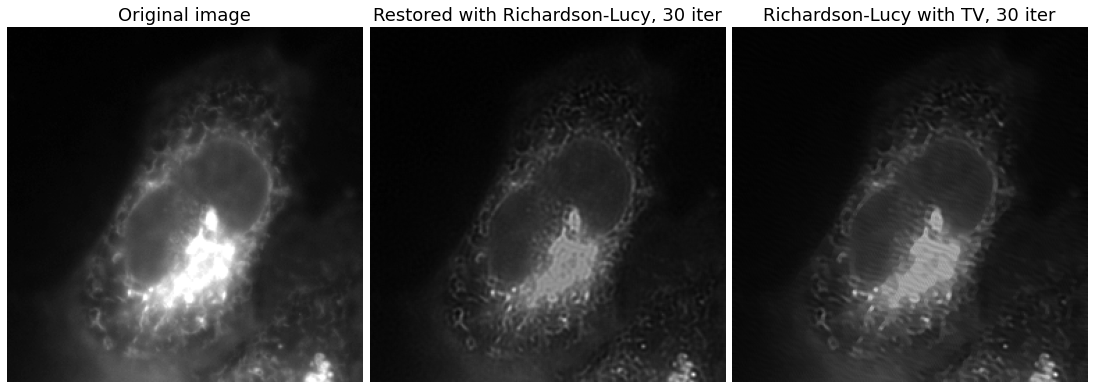

In [117]:
show_images(image1, 'Original image', im_deconv_another, 'Restored with Richardson-Lucy, 30 iter',\
           im_deconv_regulated_another, 'Richardson-Lucy with TV, 30 iter', font=18)

Higher number of iterations makes image more distorted.

## Wiener filter

This filter is linear time-invariant filter. It assumes that the degradation process can be modeled as a linear, time-invariant system affected by additive noise. The filter minimizes the mean square error between the estimated and original image

In [157]:
wiener = img_as_float(image6)

psf = kernel[:8, :8]
#psf = kernel[::-1, ::-1]
wiener_conv = convolve2d(wiener,psf,'same')

#blurred_conv += 0.1 * blurred_conv.std() * np.random.standard_normal(blurred_conv.shape)

rng = np.random.default_rng()
wiener_conv += 0.1 * wiener_conv.std() * rng.standard_normal(wiener_conv.shape)

Wiener_filtered = skimage.restoration.wiener(wiener_conv,psf,0.35) # from 0.1 to 1100

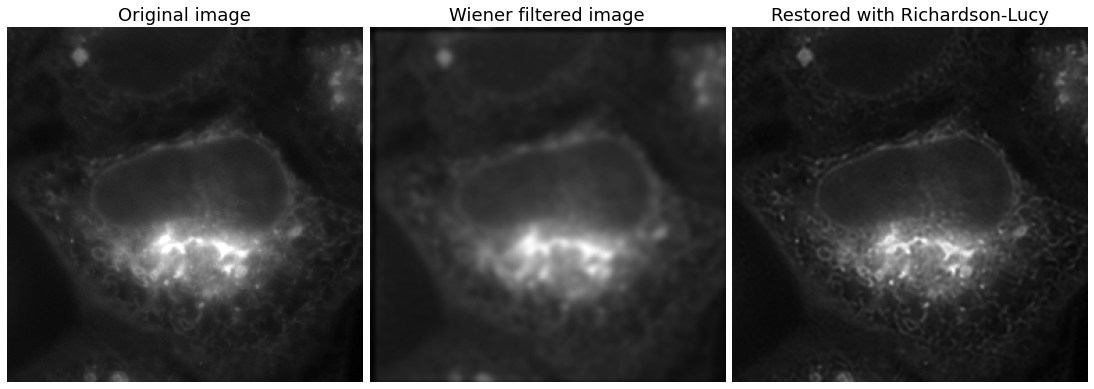

In [158]:
show_images(image6, 'Original image', Wiener_filtered, 'Wiener filtered image',\
           im_deconv, 'Restored with Richardson-Lucy', font=18)

Wiener filter significantly blurred the image.

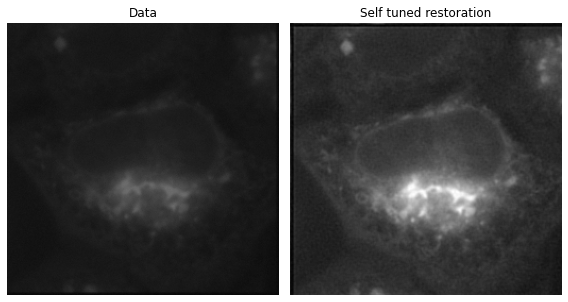

In [124]:
#Unsupervised Wiener
#This algorithm has a self-tuned regularization parameters based on data learning - Bayesian approach

wiener2 = convolve2d(wiener, psf, 'same')
wiener2 += 0.1 * wiener2.std() * rng.standard_normal(wiener2.shape)

deconvolved, _ = restoration.unsupervised_wiener(wiener2, psf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(wiener2, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()

Unsupervised Wiener seems to be less blurring than simple Wiener

#### The analysis of the output images

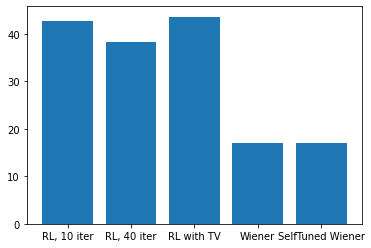

In [136]:
psnr0 = peak_signal_noise_ratio(image_true=image6, image_test=im_deconv) # RL 10 iterations
psnr1 = peak_signal_noise_ratio(image_true=image6, image_test=im_deconv3) # RL 40 iterations
psnr2 = peak_signal_noise_ratio(image_true=image6, image_test=im_deconv_regulated) # RL with TV, 10 iterations
psnr3 = peak_signal_noise_ratio(image_true=image6, image_test=Wiener_filtered) # Wiener filtered image
psnr4 = peak_signal_noise_ratio(image_true=image6, image_test=deconvolved) # Self tuned Wiener

data = {'variant_name': ['RL, 10 iter', 'RL, 40 iter', 'RL with TV', 'Wiener', 'SelfTuned Wiener'],
        'psnr': [psnr0, psnr1, psnr2, psnr3, psnr4]
        }
df = pd.DataFrame(data)


y_pos = np.arange(len(df['variant_name']))

# Create bars
plt.bar(y_pos, df['psnr'])

# Create names on the x-axis
plt.xticks(y_pos, df['variant_name'])

# Show graphic
plt.show()

Richardson-Lucy (RL) looks better than Wiener and Unsupervised Wiener. Richardson-Lucy with regularization have the highest PSNR. For the simple definition, the higher the PSNR the better the restored image, but with some stipulations.

In [137]:
#the larger the value the better the restored image - kinda
print(f"PSNR RL 10 iterations: {psnr0:.3f}")
print(f"PSNR RL 40 iterations: {psnr1:.3f}")
print(f"PSNR RL with TV: {psnr2:.3f}")
print(f"PSNR Wiener filtered image: {psnr3:.3f}")
print(f"PSNR Self tuned Wiener: {psnr4:.3f}")

PSNR RL 10 iterations: 42.750
PSNR RL 40 iterations: 38.178
PSNR RL with TV: 43.590
PSNR Wiener filtered image: 16.985
PSNR Self tuned Wiener: 16.985


In [147]:
mse_RL10 = mean_squared_error(image6, im_deconv)
ssim_RL10 = ssim(image6, im_deconv,
                  data_range=im_deconv.max() - im_deconv.min())

mse_RL40 = mean_squared_error(image6, im_deconv3)
ssim_RL40 = ssim(image6, im_deconv3,
                  data_range=im_deconv3.max() - im_deconv3.min())

mse_RLTV = mean_squared_error(image6, im_deconv_regulated)
ssim_RLTV = ssim(image6, im_deconv_regulated,
                  data_range=im_deconv_regulated.max() - im_deconv_regulated.min())

mse_Wiener = mean_squared_error(image6, Wiener_filtered)
ssim_Wiener = ssim(image6, Wiener_filtered,
                  data_range=Wiener_filtered.max() - Wiener_filtered.min())

mse_UnWiener = mean_squared_error(image6, deconvolved)
ssim_UnWiener = ssim(image6, deconvolved,
                  data_range=deconvolved.max() - deconvolved.min())


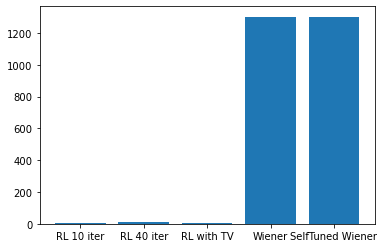

In [148]:
data2 = {'variant_name': ['RL 10 iter', 'RL 40 iter', 'RL with TV', 'Wiener', 'SelfTuned Wiener'],
        'MSE': [mse_RL10, mse_RL40, mse_RLTV, mse_Wiener, mse_UnWiener],
        'SSIM': [ssim_RL10, ssim_RL40, ssim_RLTV, ssim_Wiener, ssim_UnWiener]
        }
df2 = pd.DataFrame(data2)

y_pos = np.arange(len(df2['variant_name']))

# Create bars
plt.bar(y_pos, df2['MSE'])

# Create names on the x-axis
plt.xticks(y_pos, df2['variant_name'])

# Show graphic
plt.show()

In [151]:
#the larger the value the better the restored image - kinda
print(f"MSE RL 10 iterations: {mse_RL10:.3f}")
print(f"MSE RL 40 iterations: {mse_RL40:.3f}")
print(f"MSE RL with TV: {mse_RLTV:.3f}")
print(f"MSE Wiener filtered image: {mse_Wiener:.3f}")
print(f"MSE Self tuned Wiener: {mse_UnWiener:.3f}")

MSE RL 10 iterations: 3.452
MSE RL 40 iterations: 9.893
MSE RL with TV: 2.845
MSE Wiener filtered image: 1301.899
MSE Self tuned Wiener: 1301.883


Richardson-Lucy with regularization shown the best result, Richardson-Lucy with 10 iterations have a little bit higher error, and Richardson-Lucy with 40 have approximately 3 times higher error. Wiener filter shown the worst result here.

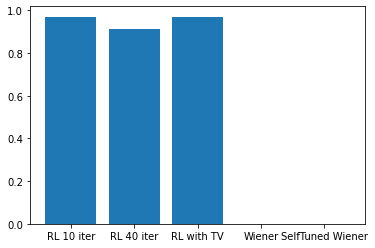

In [150]:
y_pos = np.arange(len(df2['variant_name']))

# Create bars
plt.bar(y_pos, df2['SSIM'])

# Create names on the x-axis
plt.xticks(y_pos, df2['variant_name'])

# Show graphic
plt.show()

In [152]:
#the larger the value the better the restored image - kinda
print(f"SSIM RL 10 iterations: {ssim_RL10:.3f}")
print(f"SSIM RL 40 iterations: {ssim_RL40:.3f}")
print(f"SSIM RL with TV: {ssim_RLTV:.3f}")
print(f"SSIM Wiener filtered image: {ssim_Wiener:.3f}")
print(f"SSIM Self tuned Wiener: {ssim_UnWiener:.3f}")

SSIM RL 10 iterations: 0.968
SSIM RL 40 iterations: 0.913
SSIM RL with TV: 0.970
SSIM Wiener filtered image: 0.000
SSIM Self tuned Wiener: 0.000


SSIM near 1 mainly means good image restoration, RL have a good image restoration quality.

#### Conclusion

Here we tested different algorithms, measured PSNR, MSE and SSIM. Richardson-Lucy with 10 iterations and regularization shown the best result, then the other deconvolution algorithms. Wiener shown the worst result by having big mean squared error. The outputs from convolution wasn't taken for the measurment, but this approach can be useful for the visual image enhancement.